In [17]:
import matplotlib.pyplot as plt
from matplotlib import rcParams, cm
import numpy as np
from scipy.signal import stft, resample, welch
from scipy.fft import fft, ifft
from scipy import signal
from copy import deepcopy as dc

In [18]:
def butter_bandpass(data, lowcut, highcut, fs=200, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)

In [19]:
# Imprime os gráficos
def print_graphs(datas):
    rcParams['figure.figsize'] = [16., 10.]

    x = np.linspace(0, 8, 1600)
    fig, ax = plt.subplots(len(datas), 1)

    for i in range(len(datas)):
        for j in range(4):
            ax[i].plot(x, datas[i,j])

    plt.show()

In [20]:
def print_3d_graphs(data):
    rcParams['figure.figsize'] = [18., 6.]

    for trial in (0, 1):
        mov = 1
        plot_data = []
        for channel in range(2):
            # espaço de 1600 pontos entre 0 e 1
            for i, t in enumerate(np.linspace(0, 1, 1600)):
                plot_data.append([channel, t, data[mov][trial][channel][i]])

        plot_data = np.array(plot_data)
        x, y, z = plot_data[:,0], plot_data[:,1], plot_data[:,2]
        ax = plt.axes(projection ='3d')
        ax.set_title('Movimento {}'.format(mov + 1))
        ax.set_xlabel('Canais')
        ax.set_ylabel('Tempo (s)')
        ax.set_zlabel('Potência (mV)')
        ax.plot_trisurf(x, y, z, antialiased=True, cmap=cm.inferno, linewidth=1)
        plt.show()

In [85]:
data1 = np.load('datasets/topicos_cc/s04_1.npy')
data2 = np.load('datasets/topicos_cc/s04_2.npy')
data3 = np.load('datasets/topicos_cc/s04_3.npy')

data = np.array([data1, data2, data3])
data = data.swapaxes(0, 1)
data = data.swapaxes(2, 3)

print(data.shape)

# data = butter_bandpass(data, 5, 50)

(8, 3, 4, 1600)


In [22]:
# Dados de mesma classe e diferentes ensaios
# [classes, ensaios, canais, : ]
d1 = data[0,0,0,:], data[0,0,1,:], data[0,0,2,:], data[0,0,3,:]
d2 = data[0,1,0,:], data[0,1,1,:], data[0,1,2,:], data[0,1,3,:]
d3 = data[0,2,0,:], data[0,2,1,:], data[0,2,2,:], data[0,2,3,:]

datas = np.array([d1, d2, d3])

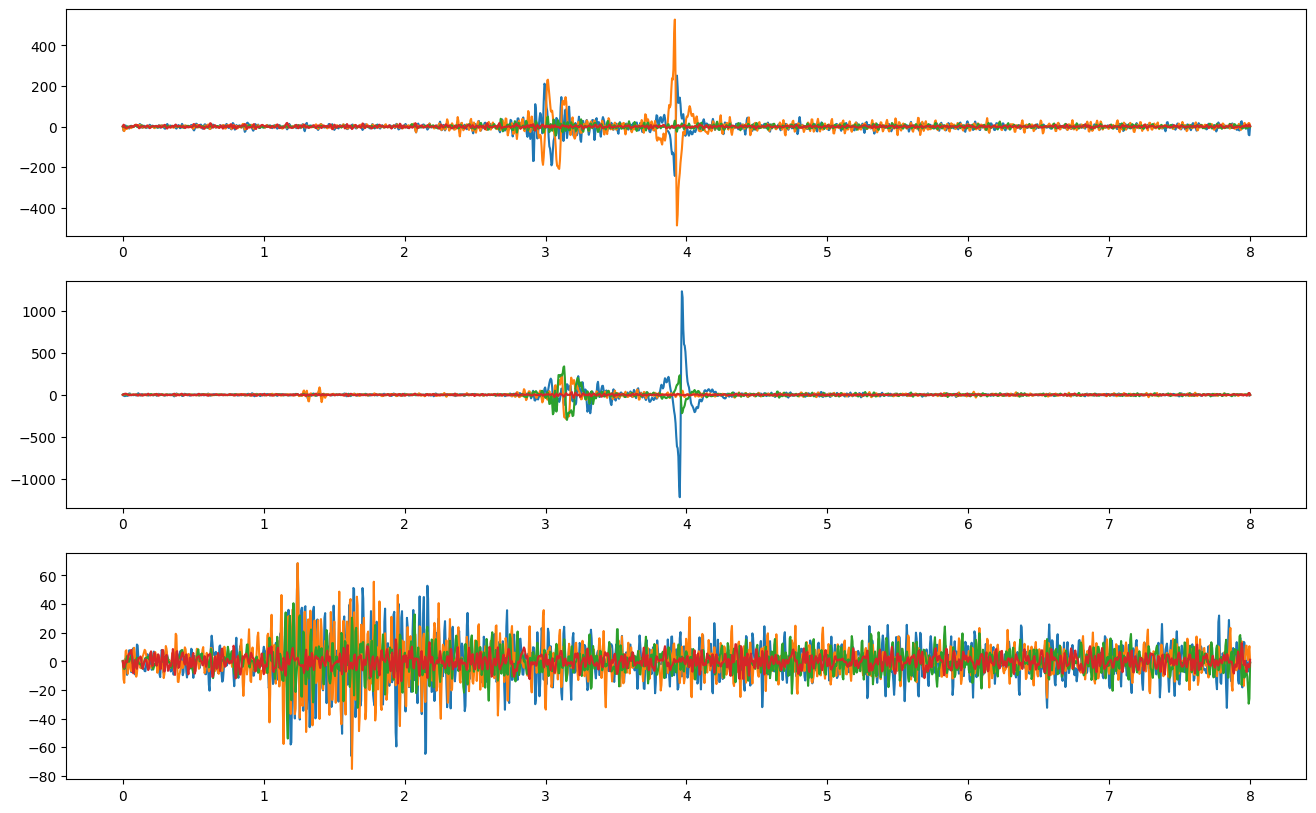

In [23]:
print_graphs(datas)

In [24]:
# Dados de diferentes classes e mesmo ensaio
# [classes, ensaios, canais, : ]
d1 = data[0,0,0,:], data[0,0,1,:], data[0,0,2,:], data[0,0,3,:]
d2 = data[1,0,0,:], data[1,0,1,:], data[1,0,2,:], data[1,0,3,:]
d3 = data[2,0,0,:], data[2,0,1,:], data[2,0,2,:], data[2,0,3,:]
d4 = data[3,0,0,:], data[3,0,1,:], data[3,0,2,:], data[3,0,3,:]
d5 = data[4,0,0,:], data[4,0,1,:], data[4,0,2,:], data[4,0,3,:]
d6 = data[5,0,0,:], data[5,0,1,:], data[5,0,2,:], data[5,0,3,:]
d7 = data[6,0,0,:], data[6,0,1,:], data[6,0,2,:], data[6,0,3,:]
d8 = data[7,0,0,:], data[7,0,1,:], data[7,0,2,:], data[7,0,3,:]

datas2 = np.array([d1, d2, d3, d4, d5, d6, d7, d8])

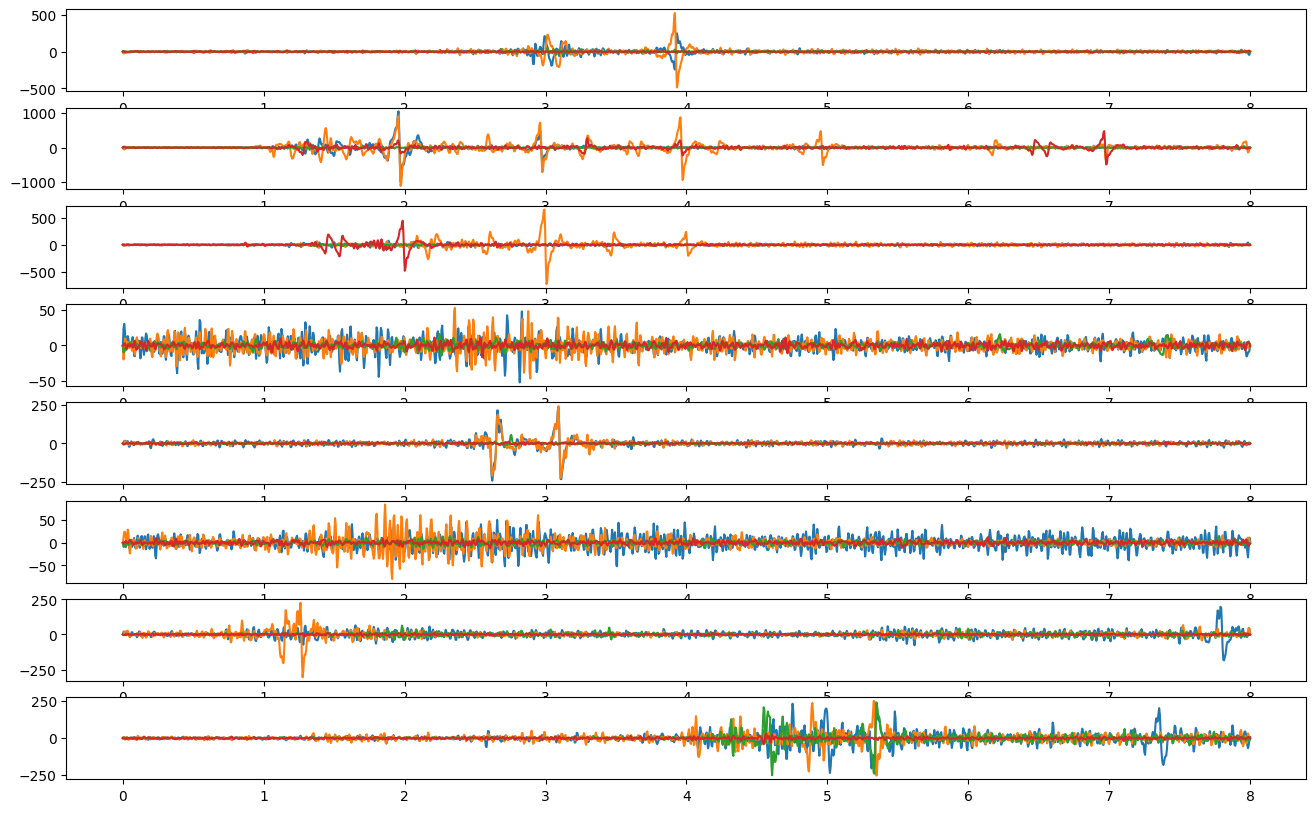

In [25]:
print_graphs(datas2)

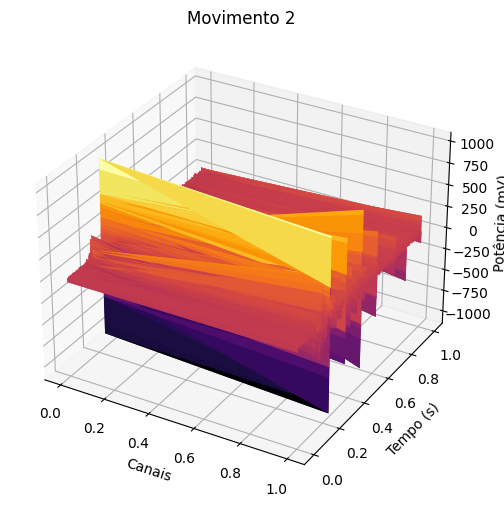

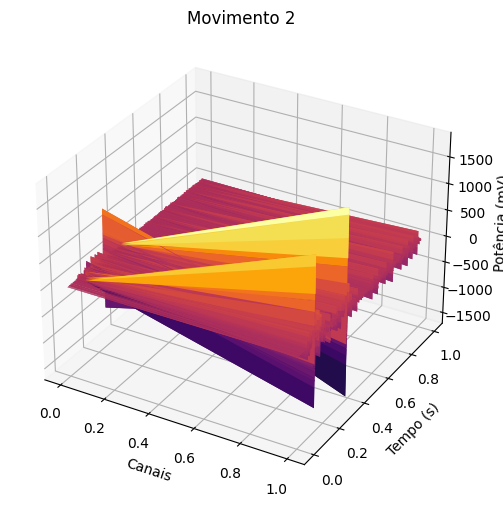

In [26]:
print_3d_graphs(data)

In [86]:
from scipy.signal import stft

step = 47
segment = 64
print('', data.shape)
dataR = data.reshape(24, 4, 1600)
print('', dataR.shape)

n_win = int((dataR.shape[-1] - segment) / step) + 1
ids = np.arange(n_win) * step

# Janelas do dado no dominio do tempo
chunks_time = np.array([dataR[:,:,k:(k + segment)] for k in ids]).transpose(1, 2, 0, 3)

# Janelas do dado no domínio da frequência
_, _, chunks_freq = stft(dataR, fs=200, nperseg=64, noverlap=32)
# chunks_freq = np.swapaxes(chunks_freq, 2, 3)

f, chunks_welch = welch(dataR, fs=200, nperseg=64, noverlap=32)

print('Formato (shape) dos dados depois da divisão de janelas')
print(f'Dominio do tempo: {chunks_time.shape} - (classes+ensaios, canais, janelas, linhas)')
print(f'Dominio da frequência:  {chunks_freq.shape} - (classes+ensaios, canais, janelas, linhas)')
print(f'Dominio da frequência (welch):  f: {f.shape}, chunks_welch: {chunks_welch.shape} - (classes+ensaios, canais, janelas, linhas)')

 (8, 3, 4, 1600)
 (24, 4, 1600)
Formato (shape) dos dados depois da divisão de janelas
Dominio do tempo: (24, 4, 33, 64) - (classes+ensaios, canais, janelas, linhas)
Dominio da frequência:  (24, 4, 33, 51) - (classes+ensaios, canais, janelas, linhas)
Dominio da frequência (welch):  f: (33,), chunks_welch: (24, 4, 33) - (classes+ensaios, canais, janelas, linhas)


In [102]:
# funções auxiliares
def PSD(w):
    ''' definição da função PSD para o sinal no domínio da frequência '''
    return np.abs(w) ** 2

def var(x):
    return np.sum(x ** 2, axis=-1) / (np.prod(x.shape) - 1)

def rms(x):
    return np.sqrt(np.sum(np.abs(x) ** 2, axis=-1) / (np.prod(x.shape) - 1))

def fmd(w):
    return np.sum(PSD(w), axis=-1) / 2

def mmdf(w):
    return np.sum(np.abs(w), axis=-1) / 2

def wamp(x, threshold=0):
    differences = np.abs(np.diff(x))
    wamp_count = np.sum(differences >= threshold, axis=-1)

    return wamp_count

def wl(x):
    differences = np.diff(x)
    wl = np.sum(np.abs(differences), axis=-1)
    return wl

def zc(x):
    crossings = np.sum(np.diff(np.sign(x)) != 0, axis=-1)
    return crossings

def fmn(w):
    fmn = np.mean(np.abs(w), axis=-1)
    return fmn

def mmnf(w):
    unique_values, counts = np.unique(np.abs(w), return_counts=True, axis=-1)
    return np.sum(unique_values * counts, axis=-1) / np.sum(counts)


In [88]:
# funções auxiliares
def PSD(w):
    ''' definição da função PSD para o sinal no domínio da frequência '''
    return np.abs(w) ** 2

##########################################
### FUNÇÕES DE EXTRAÇÃO DE CARACTERÍSTICAS

# Dominio do Tempo
# WAMP, VAR, RMS, WL, ZC
def wamp(x, threshold):
    return np.sum(np.abs(np.diff(x)) > threshold, axis=-1)

def var(x):
    return np.sum(x ** 2, axis=-1) / (np.prod(x.shape) - 1)

def rms(x):
    return np.sqrt(np.sum(np.abs(x) ** 2, axis=-1) / (np.prod(x.shape) - 1))

def wl(x):
    return np.abs(np.diff(x, axis=-1)).sum(axis=-1)

def zc(x):
    return np.sum(np.diff(np.sign(x), axis=-1) != 0, axis=-1)

# Dominio da Frequencia
# FMD, FMN, MMDF, MMNF, PSD
def fmd(w):
    return np.sum(PSD(w), axis=-1) / 2

def fmn(w):
    # sample_rate = 200
    _,_,_,M = w.shape
    f_j = (np.arange(1, M+1) * 200 )/ (2 * M)  # Frequências correspondentes a cada índice
    weighted_sum = np.sum(f_j * PSD(w))
    mean_freq = weighted_sum / fmd(w)*2
    return mean_freq

def mmdf(w):
    return np.sum(np.abs(w), axis=-1) / 2

def mmnf(w):
    # sample_rate = 200
    _,_,_,M = w.shape
    f_j = np.arange(1, M+1) * 200 / (2 * M) 
    weighted_sum = np.sum(f_j * np.abs(w), axis=-1)
    mean_freq = weighted_sum / mmdf(w)*2
    return mean_freq

In [103]:
final_data = list()
final_data.append(fmd(chunks_freq))
final_data.append(mmdf(chunks_freq))
final_data.append(fmn(chunks_freq))
final_data.append(mmnf(chunks_freq))
final_data.append(var(chunks_time))
final_data.append(rms(chunks_time))
final_data.append(wamp(chunks_time, 0))
final_data.append(wl(chunks_time))
final_data.append(zc(chunks_time))
final_data.append(chunks_welch)

final = np.array(final_data)
# print(final)
np.save("./datasets/caracteristicas/S04",final)

In [104]:
print(final.shape)
dataX = final.swapaxes(1,2)
dataX = dataX.reshape(40, 792)
dataX = dataX.swapaxes(0,1)
print("Shape: ", dataX.shape)


(10, 24, 4, 33)
Shape:  (792, 40)


In [110]:
from sklearn.preprocessing import (StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler)
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import svm, metrics


# num_samples_per_class = [int(data.shape[0] / 10) + (1 if i < data.shape[0] % 10 else 0) for i in range(10)]
# y = np.concatenate([[str(i)] * num_samples_per_class[i] for i in range(10)])
# y = np.array(y).flatten()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(dataX)
protocol = [0,1,2,3,4,5,6,7]
y = np.repeat(protocol, 99, axis=None) # 0,0,0,0,1,1,1,1,2,2,2,2,....7,7,7,7
# print(y)

# dividindo as porções de dados em treino e teste (70 e 30% respectivamente)
# com embaralhamento sempre ativo (shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=True)

# modelo de classificador com os parâmetros padrões
clf = SVC()

# criando o modelo de classificação com os dados de treino
clf.fit(X_train, y_train)

# aplicando o classificador nos dados de teste
res = clf.predict(X_test)

# obtendo e ajustando os resultados 
# tot_hit = sum([1 for i in range(len(res)) if res[i] == y_test[i]])
# print(res)
# print('Acurácia: {:.2f}%'.format(tot_hit / X_test.shape[0] * 100))
print(metrics.classification_report(y_test, res, digits=5))

              precision    recall  f1-score   support

           0    0.39286   0.42308   0.40741        26
           1    0.80952   0.91892   0.86076        37
           2    0.61905   0.40625   0.49057        32
           3    0.34722   0.80645   0.48544        31
           4    0.10000   0.02857   0.04444        35
           5    0.70588   0.46154   0.55814        26
           6    0.56000   0.56000   0.56000        25
           7    0.82609   0.73077   0.77551        26

    accuracy                        0.54202       238
   macro avg    0.54508   0.54195   0.52278       238
weighted avg    0.53811   0.54202   0.51856       238



In [111]:
from sklearn.preprocessing import (StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler)

for scaler in (StandardScaler(), MinMaxScaler(), MaxAbsScaler(), RobustScaler()):
    X_scaled = scaler.fit_transform(data)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=True)
    clf = SVC(kernel='rbf', gamma='scale')
    clf.fit(X_train, y_train)
    res = clf.predict(X_test)
    tot_hit = sum([1 for i in range(len(res)) if res[i] == y_test[i]])
    print('Acurácia: {:.2f}%'.format(tot_hit / X_test.shape[0] * 100))

Acurácia: 70.17%
Acurácia: 63.87%
Acurácia: 48.74%
Acurácia: 21.01%
